In [1]:
import pickle 

import numpy as np 

from utils import sort_and_filter_metrics, CHECKPOINT_STEPS

### Correlation between SVD and CKA Scores 

Note that the hypothesis is that as a larger matrix approaches 

First analysis we want to run if how the SVD norms correlate with the CKA scores 

In [2]:
model_size = "70m"
with open(f'/home/rd654/pretraining-playground/compiled_statistics/{model_size}/svd_weight_per_layer.pkl', 'rb') as f:
    _svd_weights = pickle.load(f)

    svd_weights__mlp = sort_and_filter_metrics(_svd_weights, "dense_4h_to_h")
    svd_weights__ov = sort_and_filter_metrics(_svd_weights, "dense_4h_to_h")

In [16]:
model_size = "70m"
with open(f"/home/rd654/pretraining-playground/compiled_statistics/{model_size}/cka_scores_per_layer.pkl", "rb") as f:
    _cka_activations = pickle.load(f)
    cka_activations__mlp = sort_and_filter_metrics(_cka_activations, "dense_4h_to_h")

In [11]:
def compute_explained_variance(S):
    """ For a matrix of singular values, compute the explained variance."""
    variances = S**2 / S.numel()
    explained_variances = variances / np.sum(variances)
    return explained_variances

def compute_condition_number(S):
    """ For a matrix of singular values, compute the condition number."""
    return S[0] / S[-1]

In [12]:
condition_numbers_per_layer = {}
for name, singular_values in svd_weights.items():

    condition_numbers_per_layer[name] = []
    for checkpoint_step, checkpoint_singular_values in zip(CHECKPOINT_STEPS, singular_values):
        S = np.array(checkpoint_singular_values)
        condition_numbers_per_layer[name].append(compute_condition_number(S))

(0.8333333333333334, 0, 0.16666666666666663)
(0.0, 0, 1.0)
(0.16666666666666666, 0, 0.8333333333333334)
(0.3333333333333333, 0, 0.6666666666666667)
(0.5, 0, 0.5)
(0.6666666666666666, 0, 0.33333333333333337)


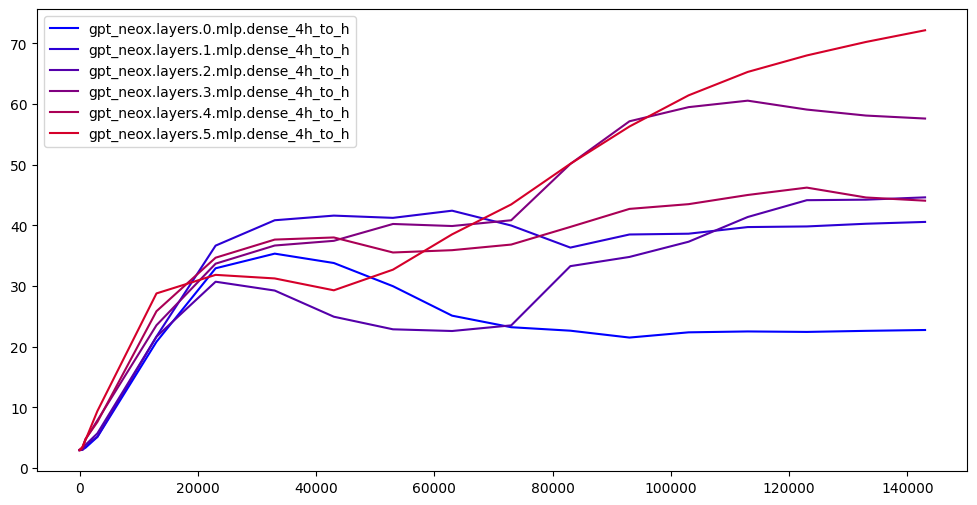

In [14]:
# plot out the condition numbers for each layer across the checkpoint steps 
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for i, (name, condition_numbers) in enumerate(condition_numbers_per_layer.items()):
    color = (i / len(condition_numbers_per_layer.keys()), 0, 1 - i / len(condition_numbers_per_layer.keys()))
    plt.plot(CHECKPOINT_STEPS, condition_numbers, label=name, color=color)

plt.legend()